In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import os
import glob

import json
import pickle
from datetime import datetime, date
from scipy import interpolate
from scipy.sparse import coo_array
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit

import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
# os.listdir(r'/content/drive/MyDrive/ad_ml')

In [ ]:
dir_path = r'/content/drive/MyDrive/ad_ml'
# path = r'/content/drive/MyDrive/chgk.zip'

# try:
#     os.mkdir(dir_path)
# except FileExistsError:
#     pass
# with zipfile.ZipFile(path, 'r') as zip_ref:
#     zip_ref.extractall(dir_path)

In [ ]:
restart = False

with open(os.path.join(dir_path, 'tournaments.pkl'), 'rb') as file:
    tournaments = pickle.load(file)
tournaments = pd.DataFrame(tournaments).T.set_index('id')

if restart:
    with open(os.path.join(dir_path, 'results.pkl'), 'rb') as file:
        results = pickle.load(file)

with open(os.path.join(dir_path, 'players.pkl'), 'rb') as file:
    players = pickle.load(file)
players = pd.DataFrame(players).T.set_index('id')



tourn_train = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2019)]
tourn_test = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2020)]

In [ ]:
# players[players.surname.str.contains('Вассерман')]

In [ ]:
train = pd.DataFrame()
def construct(results):
    data = pd.DataFrame()
    for k, v in results.items():
        
        for team in v:

            w = pd.json_normalize(team)
            try:
                w = w.explode('teamMembers')[['mask', 'teamMembers', 'team.id']].copy()
            except KeyError:
                continue
            w['player_id'] = w.teamMembers.map(
                lambda p: float('nan') 
                if isinstance(p, float) 
                else p['player']['id']
            )
            w = w[['mask', 'player_id', 'team.id']]
            w['tourn_id'] = k

            data = pd.concat((data, w), axis=0)
    return data



In [ ]:

if restart:
    results_train = {k: v for k, v in results.items() if k in tourn_train.index.tolist()}
    results_test = {k: v for k, v in results.items() if k in tourn_test.index.tolist()}

    train = construct(results_train)
    test = construct(results_test)

    with open(os.path.join(dir_path, 'train.pkl'), 'wb') as file:
        pickle.dump(train, file)
    with open(os.path.join(dir_path, 'test.pkl'), 'wb') as file:
        pickle.dump(test, file)
else:
    with open(os.path.join(dir_path, 'train.pkl'), 'rb') as file:
        train = pickle.load(file)
    with open(os.path.join(dir_path, 'test.pkl'), 'rb') as file:
        test = pickle.load(file)

print(train.player_id.unique().shape)
print(test.player_id.unique().shape)

(59217,)
(29243,)


In [ ]:

train = train[train['mask'].notna()]
train['mask'] = train['mask'].str.replace('X', '')
test['mask'] = test['mask'].str.replace('X', '')
train.head()

,mask,player_id,team.id,tourn_id
0,111111111011111110111111111100010010,6212.0,45556,4772
0,111111111011111110111111111100010010,18332.0,45556,4772
0,111111111011111110111111111100010010,18036.0,45556,4772
0,111111111011111110111111111100010010,22799.0,45556,4772
0,111111111011111110111111111100010010,15456.0,45556,4772


In [ ]:
%%script false --no-raise-error
# train[train['mask'].str.contains('X')]
# train[train.tourn_id == 4986]

train[train['mask'].str.contains('?', regex=False)]
train[((train.tourn_id == 5141) & (train['mask'].str.contains('?', regex=False)))]

In [ ]:
%%script false --no-raise-error
print(train[train.tourn_id == 5462]["mask"].str.len().describe())
# with pd.option_context('display.max_rows', 50, 'display.max_columns', 5, 'display.max_colwidth', 512):
#    print(train[train.tourn_id == 5462]["mask"].head(50))
print()

df1 = pd.DataFrame(train['tourn_id'])
df1['len_mask'] = train["mask"].str.len()

df1 = df1.groupby(['tourn_id']).agg({'len_mask': lambda x: list(x.unique())})

df2 = df1[df1.len_mask.map(lambda x: len(x)) > 1]
print(df2)

print('-----------------------------------------------------------')
print('-----------------------------------------------------------')

print("", len(df2) / train.tourn_id.unique().shape[0])

print("", len(df2.merge(train, left_on='tourn_id', right_on='tourn_id')) / len(train))


TODO: разбить турнир с разным числом вопросов в турах на несколько турниров, добавить в train

In [ ]:
%%script false --no-raise-error


tourn_w_rounds = df2.index.tolist()
tourn_w_rounds  # [5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255]
df_tourn_w_rounds = pd.DataFrame(columns=['mask',	'team.id', 'player.id',	'tourn_id'])
for file in glob.glob(dir_path + '/*.csv'):
    
    tourn_id_str = file[46:50]
    # df_tourn_w_rounds = pd.concat((df_tourn_w_rounds, ), axis=0)
    df3 = pd.read_csv(file)
    for round_id in df3['Тур'].unique():
        df_round = df3[df3['Тур'] == round_id]
        df_round.dropna(axis=1, inplace=True, how='any')
        df_round['tourn_id'] = 
df_tourn_w_rounds

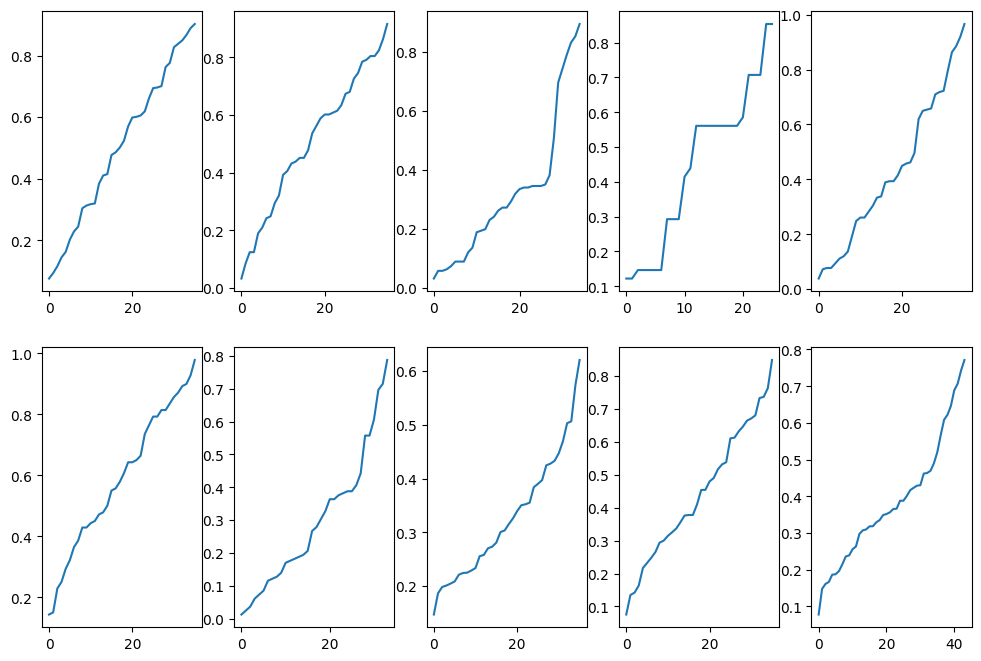

In [ ]:
sample = np.random.choice(train.tourn_id.unique(), 10)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(12, 8)
for idx, tourn_id in enumerate(sample):
    tourn = train[train.tourn_id == tourn_id]
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()

    ans_rate = pd.DataFrame(ans_mask, columns=columns).to_numpy().sum(axis=0) / ans_arr.shape[0]

    # interpolate.interp1d
    ax[idx // 5, idx % 5].plot(np.sort(ans_rate[((ans_rate > 0) & (ans_rate < 0.99999999))]))

TODO: в графиках выше считается, что все игроки команды, давшей правильный ответ, взяли вопрос. По оси $y$ доля ответивших игроков, по $x$ порядковый номер вопроса по убыванию сложности. Надо построить график с долей ответивших команд

Простота вопросов пусть будет линейная.

In [ ]:



def get_complexity_data(tourn):
    if tourn["mask"].str.len().unique().size > 1:
        # print(tourn.tourn_id.values[0])
        pass
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()
    
    q_rate = ans_arr.sum(axis=0) / ans_arr.shape[0]

    return ans_arr, q_rate



TODO: Переделать графики выше с использованием $\texttt{get_complexity_function}$ . Сделать столько же сэмплов с линейным предсказанием простоты вопросов.

Предсказываем простоту линейной функцией, выглядит похоже

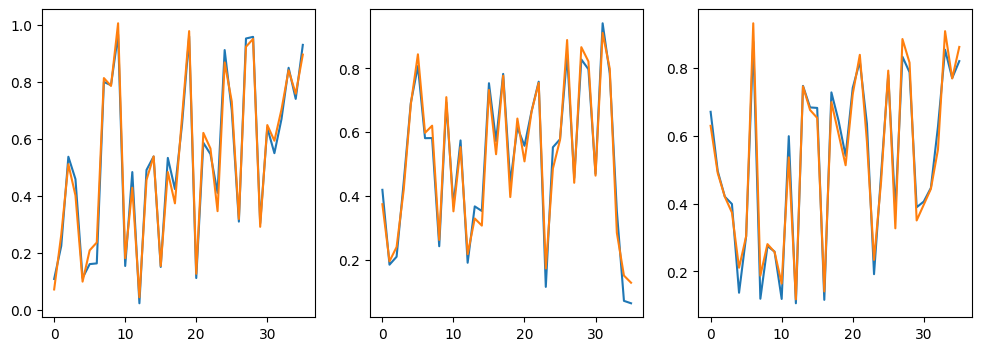

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for idx, tourn_id in enumerate(train.tourn_id.unique()[:3]):
    batch = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(batch)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))
    
    ax[idx].plot(((1 - q_rate).flatten()))
    ax[idx].plot((simplicity.flatten()))



In [ ]:

tourn_ids = train.tourn_id.unique()
player_ids = train.player_id.unique()
player_ids = player_ids[~np.isnan(player_ids)].astype(int)


player_id2idx = {}
for player_id in player_ids:
    player_id2idx[player_id] = np.argwhere(player_ids == player_id).item()

np.argwhere(player_ids == 5195).item()

5920

In [ ]:

train_simplicities = pd.Series(index=tourn_ids, dtype=object)
for tourn_idx, tourn_id in enumerate(tourn_ids):
    if tourn_id in [5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255]: # tourn_w_rounds: 
        continue
    tournament = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(tournament)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))
    train_simplicities.loc[tourn_id] = simplicity

Время выполнения двух следующих ячеек при перезапуске может занять полчаса каждая

In [ ]:
if restart:  ## EXECUTION TIME ~2 HOURS
    rowX  = np.empty((40_000_000, 1))
    colX  = np.empty((40_000_000, 1))
    dataX = np.empty((40_000_000, 1))
    sample_idx = 0

    for tourn_idx, tourn_id in enumerate(tourn_ids):
        if tourn_id in tourn_w_rounds: 
            continue
        tournament = train[train.tourn_id == tourn_id]
        ans_arr, q_rate = get_complexity_data(tournament)

        simplicity = train_simplicities[tourn_id]
        assert ans_arr.shape[0] == len(tournament)
        
        
        for tourn_row_idx, (player_id, answers) in enumerate(zip(tournament.player_id, ans_arr)):
            try:
                player_id = int(player_id)
            except Exception as e:
                # print(e)
                # print(tourn_idx)  # tourn_idxes where player_id NaN: 4 22 251 379 383 384 395 462 546 564 573 597
                continue
            
            for que_idx, (question_rate, answer) in enumerate(zip(simplicity, answers)):
                rowX[sample_idx] = sample_idx // 2
                colX[sample_idx] = tourn_idx
                dataX[sample_idx] = question_rate
            
                rowX[sample_idx + 1] = sample_idx // 2
                colX[sample_idx + 1] = len(tourn_ids) + player_id2idx[player_id]
                dataX[sample_idx + 1] = 1

                sample_idx += 2

    rowX = rowX[:sample_idx]
    colX = colX[:sample_idx]
    dataX = dataX[:sample_idx]

    X_train = coo_array( 
        (dataX.squeeze(), (rowX.squeeze(), colX.squeeze())), 
        shape=(sample_idx // 2, len(tourn_ids) + len(player_ids))
    )
    with open(os.path.join(dir_path, 'X_train.pkl'), 'wb') as file:
        pickle.dump(X_train, file)

else: 
    with open(os.path.join(dir_path, 'X_train.pkl'), 'rb') as file:
        X_train = pickle.load(file)
    


TODO
2. Внутренний цикл можно убрать, станет быстрее
3. nan в игроках можно заранее дропнуть

In [ ]:
if restart:  
    y_train = pd.DataFrame(
        index=range(20_000_000), 
        columns=['tourn_id', 'team_id', 'que_idx', 'numerator', 'denominator', 'value']
    )

    sample_idx = 0

    for tourn_idx, tourn_id in enumerate(tourn_ids):
        if tourn_id in tourn_w_rounds: 
            continue
        tournament = train[train.tourn_id == tourn_id]
        ans_arr, q_rate = get_complexity_data(tournament)

        simplicity = train_simplicities[tourn_id]
        assert ans_arr.shape[0] == len(tournament)
        
        
        for tourn_row_idx, (team_id, player_id, answers) in enumerate(zip(tournament['team.id'], tournament.player_id, ans_arr)):
            try:
                player_id = int(player_id)
            except Exception as e:
                # print(e)
                # print(tourn_idx)  # tourn_idxes where player_id NaN: 4 22 251 379 383 384 395 462 546 564 573 597
                continue
            
            for que_idx, (question_rate, answer) in enumerate(zip(simplicity, answers)):
                y_train.iloc[sample_idx, [0, 1, 2, 5]] = [tourn_id, team_id, que_idx, answer]

                sample_idx += 1

    y_train = y_train.iloc[:sample_idx, :]

    
    with open(os.path.join(dir_path, f'y_train_0.pkl'), 'wb') as file:
        pickle.dump(y_train.iloc[:len(y_train) // 2], file)

    with open(os.path.join(dir_path, f'y_train_1.pkl'), 'wb') as file:
        pickle.dump(y_train.iloc[len(y_train) // 2:], file)
    

else: 
    with open(os.path.join(dir_path, f'y_train_0.pkl'), 'rb') as file1, \
        open(os.path.join(dir_path, f'y_train_1.pkl'), 'rb') as file2:
        y_train = pd.concat((pickle.load(file1), pickle.load(file2)), axis=0)


## Baseline:

In [ ]:

lr = LogisticRegression(max_iter=10000, warm_start=True)
lr.fit(X_train, y_train.value.to_numpy().astype(int))

LogisticRegression(max_iter=10000, warm_start=True)

In [ ]:
rating_tourn = lr.coef_[0, :len(tourn_ids)]
rating_players = lr.coef_[0, len(tourn_ids):]
print(rating_tourn.min(), rating_tourn.max())
print(rating_players.min(), rating_players.max())

-14.145534589656382 0.0
-3.2467042153889993 3.901418386892662


In [ ]:
# 
tourn_train.loc[tourn_ids[np.argpartition(rating_tourn[rating_tourn < 0], -10)[-10:]]]
# rating_tourn[np.argpartition(rating_tourn, -10)]

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
5693,Знание – Сила VI,2019-08-16T19:00:00+03:00,2019-08-20T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 36120, 'name': 'Серафим', 'patronymic'...",{'dateRequestsAllowedTo': '2019-08-20T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5564,Молодёжный чемпионат Нижегородской области,2019-02-01T00:00:00+03:00,2019-03-03T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 32901, 'name': 'Наиль', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, ..."
5785,Зеркало Знатокиады,2019-07-19T18:00:00+03:00,2019-07-23T18:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 7119, 'name': 'Арсений', 'patronymic':...",{'dateRequestsAllowedTo': '2019-07-23T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5947,Чемпионат Мира. Этап 3. Группа С,2019-09-08T11:00:00+03:00,2019-09-08T13:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
5457,Студенческий чемпионат Калининградской области,2019-02-16T14:00:00+03:00,2019-02-16T19:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 90340, 'name': 'Дмитрий', 'patronymic'...",None,"{'1': 15, '2': 15, '3': 15}"
5948,Чемпионат Мира. Финал. Группа А,2019-09-08T15:30:00+03:00,2019-09-08T17:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
5982,ОК СПбГУ,2019-11-24T12:00:00+03:00,2019-11-24T18:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 119352, 'name': 'Матвей', 'patronymic'...",None,"{'1': 15, '2': 15, '3': 15, '4': 15}"
6123,Чемпионат МГУ. Открытая лига. Второй игровой день,2019-12-09T19:00:00+03:00,2019-12-09T22:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 5990, 'name': 'Андрей', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12}"
5927,Кубок пустого стула,2019-11-08T19:00:00+03:00,2019-11-12T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 4414, 'name': 'Александр', 'patronymic...",{'dateRequestsAllowedTo': '2019-11-11T23:59:00...,"{'1': 12, '2': 12, '3': 12}"


In [ ]:
players.loc[player_ids[np.argpartition(rating_players, -10)[-10:]]]


,name,patronymic,surname
id,,,
26089,Ирина,Сергеевна,Прокофьева
22799,Сергей,Игоревич,Николенко
20691,Станислав,Григорьевич,Мереминский
18036,Михаил,Ильич,Левандовский
30152,Артём,Сергеевич,Сорожкин
27822,Михаил,Владимирович,Савченков
27403,Максим,Михайлович,Руссо
30270,Сергей,Леонидович,Спешков
28751,Иван,Николаевич,Семушин


Предсказание сложности турниров похоже на правду, рейтинг игроков похож на рейтинг за 2019 год.

In [ ]:
from scipy import stats

def evaluate(rating_players):
    res = []
    for _, tourn_id in enumerate(test.tourn_id.unique()):
        df = pd.DataFrame()
        
        tourn = test[test.tourn_id == tourn_id].copy()
        tourn['performance_predicted'] = 0
        tourn['performance_actual'] = 0
        try:
            ans_arr, _ = get_complexity_data(tourn)
        except TypeError:
            continue
        assert len(tourn) == ans_arr.shape[0]
        for idx, answers in zip(range(len(tourn)), ans_arr):
            try:
              
                player_idx = player_id2idx[int(tourn.iloc[idx, 1])]
            except (ValueError, KeyError):
                tourn.iloc[idx, 4] = np.nan
            else:
                #
                tourn.iloc[idx, 4] = rating_players[player_idx]
            
            tourn.iloc[idx, 5] = answers.sum()

        tourn.dropna(axis=0, inplace=True, how='any')
        # tourn.set_index('player_id')
        
        res.append([
            stats.spearmanr(tourn['performance_actual'], tourn['performance_predicted']).statistic, 
            stats.kendalltau(tourn['performance_actual'], tourn['performance_predicted']).statistic
        ])
    res = np.asarray(res)
    return np.nanmean(res, axis=0) # array([0.72223742, 0.55741029])

# Турниры, где есть несколько туров, тестовое множество
# 5477
# 5705
# 5710
# 5733
# 6172
# 6265
# 6307
# 6308

In [ ]:
evaluate(rating_players)  

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


array([0.72223742, 0.55741029])

Ранговые корреляции [0.72223742, 0.55741029]

## EM-алгоритм

In [ ]:
lin = nn.Linear(lr.coef_.shape[1], 2)
with torch.no_grad():
    lin.weight.copy_(torch.from_numpy(np.vstack((-lr.coef_, lr.coef_))))

# lr2 = nn.Sequential(
#     nn.Linear(lr.coef_.shape[1], 1),
#     # nn.Sigmoid()
# )

loss_function = nn.BCELoss()
opt = torch.optim.Adam(lin.parameters(), lr=1.e-1)

In [ ]:
values = X_train.data
indices = np.vstack((X_train.row, X_train.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = X_train.shape

X_train_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))
X_train_torch.requires_grad = False

Скрытые переменные $z_{ij}$ - $i$-ый игрок ответил на $j$-ый вопрос

In [ ]:
import time
y_target = torch.Tensor(16153927, 2)

n_iter = 600
losses = np.empty((n_iter,))
for _ in range(3):
    t0 = time.time()
    with torch.no_grad():
        sig_feat_dot_w = (1 / (1 + np.exp(-lin(X_train_torch)[:, 1]))).unsqueeze(-1)
        
        y_train['numerator'] = np.where(np.expand_dims(y_train.value.to_numpy(), -1), sig_feat_dot_w, 0)
        
        y_train['denominator'] = 1 - y_train['numerator']
        df_tourn_team_que_denominators = y_train[['tourn_id', 'que_idx', 'team_id', 'denominator']]\
            .groupby(['tourn_id', 'que_idx', 'team_id'])\
            .agg(np.prod)\
            .reset_index()
        
        y_train.denominator = y_train[['tourn_id', 'que_idx', 'team_id']]\
            .merge(df_tourn_team_que_denominators, how='left', on=['tourn_id', 'que_idx', 'team_id'])['denominator']
        y_train.denominator = 1. - y_train.denominator
        y_train.denominator = np.where(y_train.iloc[:, 5:6].to_numpy(), y_train.iloc[:, 4:5].to_numpy(), 1)
        
        t1 = time.time()
        print(f'phase 1 done: {t1 - t0} s')
        t0 = t1
    
    for i_iter in range(n_iter):
        y_predicted = 1 / (1 + torch.exp(-lin(X_train_torch)))
        
        y_target[:, 1] = torch.Tensor(y_train['numerator']/y_train['denominator'])
        y_target[:, 0] = 1 - y_target[:, 1]
        # torch.clamp(y_target, 1.e-8, 1 - 1.e-8)
        # y_target[:, :] = torch.log(y_target/(1 - y_target))
        
        loss = loss_function(y_predicted, y_target)
        losses[i_iter] = loss.detach().item()
        if i_iter % 30 == 0:
            print(losses[i_iter])
        if i_iter > 10 and loss > losses[i_iter-10:i_iter].mean().item():
            print(i_iter)
            break
        loss.backward()
        opt.step()
        opt.zero_grad()
        # with torch.no_grad():
        #     coefficients = lin.weight.data.numpy()
        # rating_players = coefficients[0, len(tourn_ids):]
        # rating_tourn = coefficients[0, :len(tourn_ids)]
        # print(evaluate(rating_players))

    t1 = time.time()
    print(f'phase 2 done: {t1 - t0} s')
    t0 = t1
    # 
    
    with torch.no_grad():
        coefficients = lin.weight.data.numpy()
    rating_players = coefficients[1, len(tourn_ids):]
    rating_tourn = coefficients[1, :len(tourn_ids)]
    print(evaluate(rating_players))
    print('--------------------------------------------------------')


phase 1 done: 45.21315813064575 s
0.3299317955970764
0.3283604681491852
0.32832247018814087
0.3283204138278961
0.32832011580467224
0.3283199667930603
0.32831984758377075
0.3283197581768036
0.3283197283744812
250
phase 2 done: 2237.161113023758 s


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[0.71292584 0.54899086]
--------------------------------------------------------
phase 1 done: 45.70360589027405 s
0.3263895809650421
0.3257879614830017
0.32577967643737793
0.3257787525653839
98
phase 2 done: 863.2678110599518 s


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[0.7005075  0.53711756]
--------------------------------------------------------
phase 1 done: 36.49315857887268 s
0.3238833248615265
0.32357683777809143
0.32356852293014526
84
phase 2 done: 744.8884537220001 s
[0.6881029  0.52582771]
--------------------------------------------------------


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


ЕМ-алгоритм как будто сходится, но ранговые корреляции падают, почему - непонятно. Единственная гипотеза - выучиваются сложности турниров, вместо силы игроков. Топ игроков явно испортился. Но может дело в том, что рейтинг больше растет у игроков, которые сыграли мало вопросов.

In [ ]:
print(rating_tourn.min(), rating_tourn.max())
print(rating_players.min(), rating_players.max())

-16.94294 0.0
-6.7239113 4.3231363


In [ ]:
tourn_train.loc[tourn_ids[np.argpartition(rating_tourn[rating_tourn < 0], -10)[-10:]]]

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
5847,Байкальский фестиваль,2019-08-10T07:00:00+03:00,2019-08-11T14:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 39218, 'name': 'Владислав', 'patronymi...",None,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, ..."
5693,Знание – Сила VI,2019-08-16T19:00:00+03:00,2019-08-20T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 36120, 'name': 'Серафим', 'patronymic'...",{'dateRequestsAllowedTo': '2019-08-20T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5698,(а)Синхрон-lite. Лига старта. Эпизод VII,2019-09-01T00:05:00+03:00,2019-09-30T23:55:00+03:00,"{'id': 8, 'name': 'Асинхрон'}",/seasons/53,"[{'id': 23740, 'name': 'Владимир', 'patronymic...",{'dateRequestsAllowedTo': '2019-09-29T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5948,Чемпионат Мира. Финал. Группа А,2019-09-08T15:30:00+03:00,2019-09-08T17:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
6123,Чемпионат МГУ. Открытая лига. Второй игровой день,2019-12-09T19:00:00+03:00,2019-12-09T22:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 5990, 'name': 'Андрей', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12}"
5947,Чемпионат Мира. Этап 3. Группа С,2019-09-08T11:00:00+03:00,2019-09-08T13:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
5564,Молодёжный чемпионат Нижегородской области,2019-02-01T00:00:00+03:00,2019-03-03T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 32901, 'name': 'Наиль', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, ..."
5457,Студенческий чемпионат Калининградской области,2019-02-16T14:00:00+03:00,2019-02-16T19:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 90340, 'name': 'Дмитрий', 'patronymic'...",None,"{'1': 15, '2': 15, '3': 15}"
5927,Кубок пустого стула,2019-11-08T19:00:00+03:00,2019-11-12T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 4414, 'name': 'Александр', 'patronymic...",{'dateRequestsAllowedTo': '2019-11-11T23:59:00...,"{'1': 12, '2': 12, '3': 12}"


In [ ]:
players.loc[player_ids[np.argpartition(rating_players, -10)[-10:]]]

,name,patronymic,surname
id,,,
188876,Мария,Юрьевна,Голудина
40411,Дмитрий,Сергеевич,Кудинов
28751,Иван,Николаевич,Семушин
4270,Александра,Владимировна,Брутер
27403,Максим,Михайлович,Руссо
190096,Дмитрий,Михайлович,Мартьянов
38175,Максим,Игоревич,Пилипенко
17750,Галина,Вячеславовна,Лазарева
139576,Сергей,Александрович,Майер


Вообще, можно попробовать корреляцию мерить по командной игре. В результатах все равно только она видна. Тогда надо считать при ответе на вопрос вероятность, что команда не ответит = ни один из игроков команды не ответит.

In [ ]:

from scipy.stats import rankdata
from scipy.special import expit

def evaluate2(rating_players): 
    
    res = []
    for _, tourn_id in enumerate(test.tourn_id.unique()):
        df = pd.DataFrame()
        
        tourn = test[test.tourn_id == tourn_id].copy()
        
        tourn['performance_predicted'] = 0
        tourn['performance_actual'] = 0
        ################################################
        try:
            ans_arr, _ = get_complexity_data(tourn)
        except TypeError:
            continue
        assert len(tourn) == ans_arr.shape[0]
        

        tourn['value'] = tourn.player_id.map(lambda x: rating_players[player_id2idx[int(x)]] if x.is_integer() and int(x) in player_id2idx else np.nan)
        tourn['value'] = 1 - expit(tourn.value)
        tourn.dropna(axis=0, how='any')
        tourn['performance_actual'] = tourn['mask'].str.count('1')
        performance = tourn[['value', 'team.id']].groupby('team.id').agg(np.prod).reset_index()

        performance = performance.merge(tourn[['team.id', 'performance_actual']], how='inner', on='team.id').drop_duplicates(['team.id', 'value', 'performance_actual'])
        performance['performance_pred'] = 1 - performance.value

        res.append([
            stats.spearmanr(performance['performance_actual'], performance['performance_pred']).statistic, 
            stats.kendalltau(performance['performance_actual'], performance['performance_pred']).statistic
        ])
    res = np.asarray(res)
    return np.nanmean(res, axis=0) # array([0.72223742, 0.55741029])

evaluate2(rating_players)

array([0.7742058 , 0.61620167])

In [ ]:
rating_players0 = lr.coef_[0, len(tourn_ids):].T
print(evaluate2(rating_players0.astype('float32')))
print(evaluate2(rating_players))

[0.77306879 0.6153344 ]
[0.7742058  0.61620167]


При попытке оценить командную игру корреляции растут. Что и требовалось.. насчитать. 

